# Kernel Scan - Quick Start Example

This notebook demonstrates the kernel_scan library's API as shown in the README's Quick Start section.

In [15]:
import logging
import sys
from pathlib import Path
import os
import polars as pl

# Configure logging
logging.basicConfig(
    level=logging.DEBUG, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
log = logging.getLogger(__name__)

## Add source directory to path

This is important for imports to work correctly when running in a notebook.

In [4]:
# Add the src directory to sys.path to import kernel_scan
# Get the parent directory of the notebook directory (project_root)
notebook_path = Path(os.getcwd())
project_root = notebook_path.parent.parent
src_path = project_root / "src"

# Add the src path to sys.path if it's not already there
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

print(f"Added {src_path} to Python path")

Added /home/anders/projects/kernel_scan/src to Python path


## Import kernel_scan modules

Now we can import the necessary modules from kernel_scan.

In [5]:
try:
    # Import kernel_scan modules
    from kernel_scan import (
        DataType,
        EngineType,
        KernelSpec,
        Layout,
        OperationType,
        Profiler,
    )
    from kernel_scan.core.types import TensorSpec
    from kernel_scan.ops import GemmParams
    from kernel_scan.visualization import generate_gemm_roofline_plots_by_group
    
    print("Successfully imported kernel_scan modules")
except ImportError as e:
    log.error(f"Error importing kernel_scan: {e}")
    log.error(
        "Make sure the kernel_scan package is properly installed or in the Python path."
    )

Successfully imported kernel_scan modules


## Create a GEMM kernel specification

First, we'll create a kernel specification for a General Matrix Multiplication (GEMM) operation.

In [6]:
# Create output directories if they don't exist
results_dir = project_root / "results"
plots_dir = project_root / "plots"

results_dir.mkdir(exist_ok=True)
plots_dir.mkdir(exist_ok=True)

In [7]:
# Create a GEMM kernel specification
log.info("Creating GEMM kernel specification...")

kernel_spec = (
    KernelSpec.builder()
    .operation_type(OperationType.GEMM)
    .data_type(DataType.FLOAT32)
    .operation_params(
        GemmParams(
            m=1024,
            n=1024,
            k=1024,
            alpha=1.0,
            beta=0.0,
            layout_a=Layout.ROW_MAJOR,
            layout_b=Layout.ROW_MAJOR,
            layout_c=Layout.ROW_MAJOR,
        )
    )
    .inputs(
        a=TensorSpec.create_2d(1024, 1024, Layout.ROW_MAJOR, DataType.FLOAT32),
        b=TensorSpec.create_2d(1024, 1024, Layout.ROW_MAJOR, DataType.FLOAT32),
    )
    .outputs(c=TensorSpec.create_2d(1024, 1024, Layout.ROW_MAJOR, DataType.FLOAT32))
    .iterations(10)  # Reduced for quick example
    .build()
)
log.info("Kernel specification created successfully.")

2025-06-17 15:04:25,939 - __main__ - INFO - Creating GEMM kernel specification...
2025-06-17 15:04:25,939 - __main__ - INFO - Kernel specification created successfully.


## Initialize Profiler and Run Profiling

Now we'll initialize the profiler and run the profiling with the ComposableKernel engine.

In [8]:
# Profile with a specific engine
log.info("Initializing profiler...")
profiler = Profiler()

log.info("Profiling with ComposableKernelEngine...")
try:
    # Pass the detected accelerator specs to the profiler
    result_set = profiler.profile_with_engine(
        kernel_spec,
        EngineType.COMPOSABLE_KERNEL,
        warmup_iterations=2,
        output_file=str(results_dir / "quickstart_notebook.jsonl"),
    )
    print(f"Profiling complete. Results saved to {results_dir / 'quickstart_notebook.jsonl'}")
except Exception as e:
    log.error(f"Error during profiling: {e}")
    raise e

2025-06-17 15:04:30,607 - __main__ - INFO - Initializing profiler...
2025-06-17 15:04:30,607 - __main__ - INFO - Profiling with ComposableKernelEngine...
2025-06-17 15:04:30,713 - kernel_scan.core.accelerator - INFO - Detected AMD GPU: Radeon RX 7900 XTX
2025-06-17 15:04:30,713 - kernel_scan.core.accelerator - INFO - Found matching GPU model: Radeon RX 7900 XTX from vendor AMD
2025-06-17 15:04:30,714 - kernel_scan.engines.composable_kernel_engine - INFO - Detected hardware: Radeon RX 7900 XTX
2025-06-17 15:04:30,714 - kernel_scan.engines.composable_kernel_engine - INFO - Running ckProfiler with arguments: /opt/rocm/bin/ckProfiler gemm 0 0 1 0 0 1 1024 1024 1024 1024 1024 1024 2 10 -o jsonl=/home/anders/projects/kernel_scan/results/quickstart_notebook.jsonl


Profiling complete. Results saved to /home/anders/projects/kernel_scan/results/quickstart_notebook.jsonl


## Visualize Results with Roofline Plot

Now we'll visualize the profiling results using a roofline plot.

In [9]:
# Add debug to see what's in the results
print(f"Result set contains {len(result_set.results)} results")
print(f"Accelerator: {result_set.accelerator_specs.name}")
print(f"Peak compute: {result_set.accelerator_specs.get_peak_compute(DataType.FLOAT32)} TFLOPS")
print(f"Peak bandwidth: {result_set.accelerator_specs.peak_bandwidth} GB/s")

Result set contains 25 results
Accelerator: Radeon RX 7900 XTX
Peak compute: 61.4 TFLOPS
Peak bandwidth: 960.0 GB/s


In [10]:
# Look at the raw dataframe
df = result_set.dataframe
display(df.head())

operation,time_ms,tflops,gb_per_sec,is_best,timestamp,N,M,layout_b,output_datatype,K,weight_datatype,input_datatype,layout_c,layout_a,datatype,operation_type
str,f64,f64,f64,bool,str,i64,i64,str,str,i64,str,str,str,str,str,str
"""DeviceGemmDl<256, 128, 128, 16…",0.663739,3.23543,18.9576,false,"""2025-06-17T13:04:31.445Z""",1024,1024,"""RowMajor""","""f32""",1024,"""f32""","""f32""","""RowMajor""","""RowMajor""","""f32""","""gemm"""
"""DeviceGemmDl<256, 128, 128, 16…",0.316627,6.78237,39.7404,false,"""2025-06-17T13:04:31.451Z""",1024,1024,"""RowMajor""","""f32""",1024,"""f32""","""f32""","""RowMajor""","""RowMajor""","""f32""","""gemm"""
"""DeviceGemmDl<256, 128, 128, 16…",0.298055,7.20499,42.2167,false,"""2025-06-17T13:04:31.456Z""",1024,1024,"""RowMajor""","""f32""",1024,"""f32""","""f32""","""RowMajor""","""RowMajor""","""f32""","""gemm"""
"""DeviceGemmDl<128, 128, 64, 16,…",0.250567,8.57051,50.2178,false,"""2025-06-17T13:04:31.461Z""",1024,1024,"""RowMajor""","""f32""",1024,"""f32""","""f32""","""RowMajor""","""RowMajor""","""f32""","""gemm"""
"""DeviceGemmDl<128, 128, 64, 16,…",0.244222,8.79314,51.5223,false,"""2025-06-17T13:04:31.466Z""",1024,1024,"""RowMajor""","""f32""",1024,"""f32""","""f32""","""RowMajor""","""RowMajor""","""f32""","""gemm"""


2025-06-17 15:05:15,289 - kernel_scan.visualization.plots - DEBUG - DataFrame columns: ['operation', 'time_ms', 'tflops', 'gb_per_sec', 'is_best', 'timestamp', 'N', 'M', 'layout_b', 'output_datatype', 'K', 'weight_datatype', 'input_datatype', 'layout_c', 'layout_a', 'datatype', 'operation_type']
2025-06-17 15:05:15,290 - kernel_scan.visualization.plots - DEBUG - DataFrame sample: shape: (2, 17)
┌─────────────┬──────────┬─────────┬────────────┬───┬──────────┬──────────┬──────────┬─────────────┐
│ operation   ┆ time_ms  ┆ tflops  ┆ gb_per_sec ┆ … ┆ layout_c ┆ layout_a ┆ datatype ┆ operation_t │
│ ---         ┆ ---      ┆ ---     ┆ ---        ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ype         │
│ str         ┆ f64      ┆ f64     ┆ f64        ┆   ┆ str      ┆ str      ┆ str      ┆ ---         │
│             ┆          ┆         ┆            ┆   ┆          ┆          ┆          ┆ str         │
╞═════════════╪══════════╪═════════╪════════════╪═══╪══════════╪══════════╪══════════╪═══════════

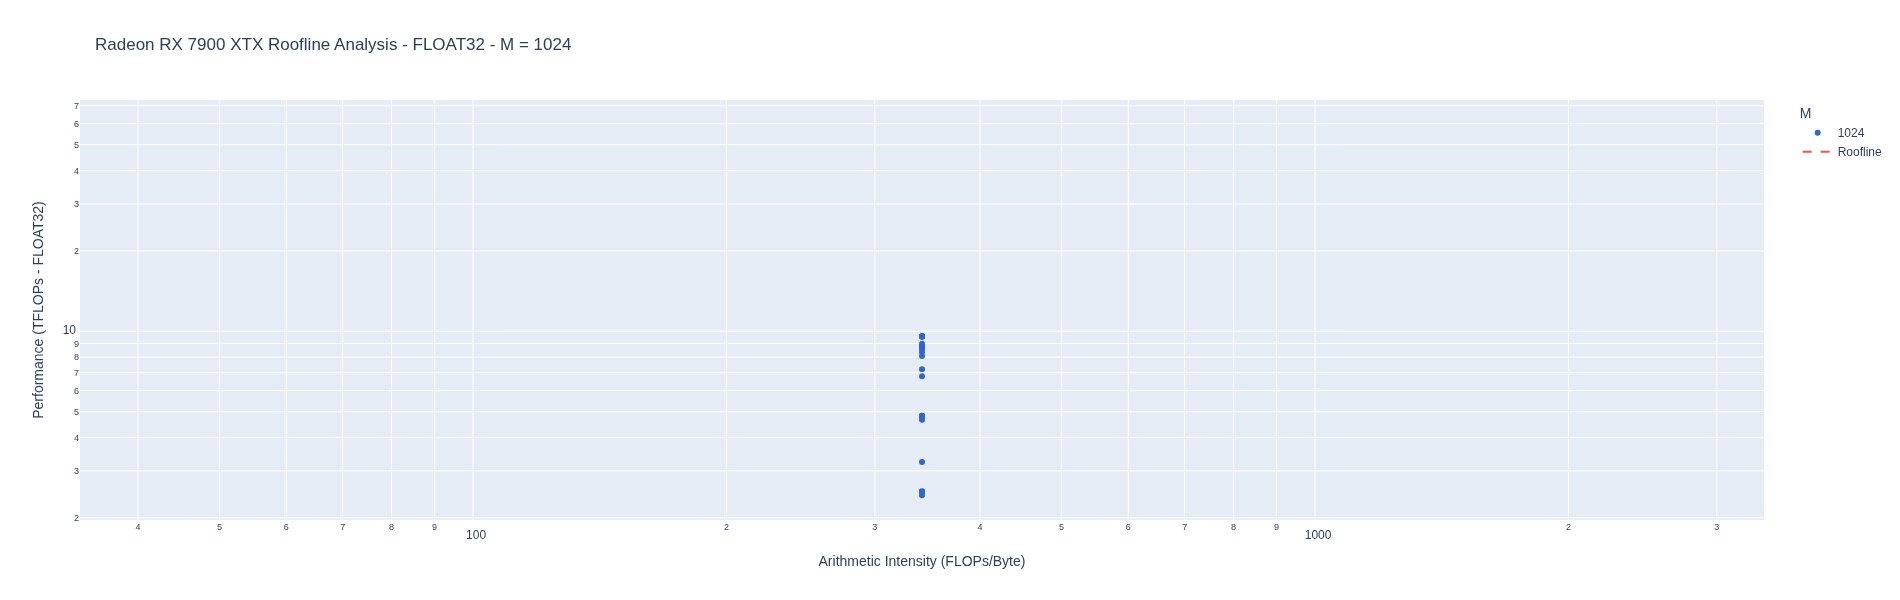

In [12]:
try:
    # Generate roofline plots
    figures = generate_gemm_roofline_plots_by_group(result_set)
    
    for group, fig in figures.items():
        fig.show()
        
except Exception as e:
    log.error(f"Error during plotting: {e}")
    raise e

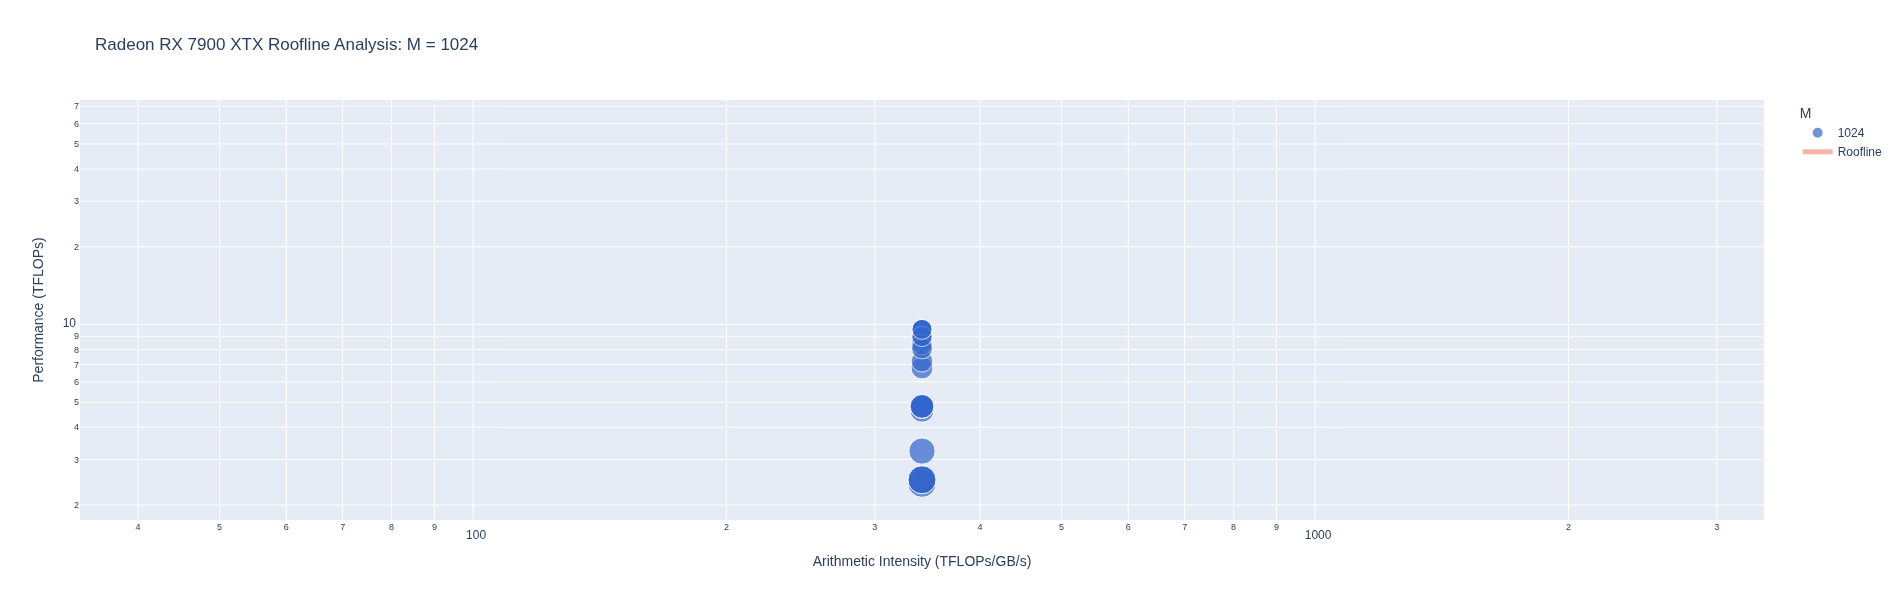

In [16]:
# Generate plots using the working implementation
try:
    peak_compute = result_set.accelerator_specs.get_peak_compute(DataType.FLOAT32)
    peak_bandwidth = result_set.accelerator_specs.peak_bandwidth
    
    figures = generate_roofline_plots_by_group(result_set.dataframe, peak_compute, peak_bandwidth)
    
    # Save and display the figures
    for group, fig in figures.items():
        # Display the figure in the notebook
        fig.show()
        
except Exception as e:
    log.error(f"Error during plotting: {e}")
    raise e

## Conclusion

This notebook has demonstrated:
1. Setting up a GEMM kernel specification
2. Profiling the kernel using the ComposableKernel engine
3. Visualizing the results with roofline plots
4. Improving the visualization with square root scaling for point sizes

The square root scaling of the time_ms values for point sizes helps to make the visualization more effective, as extremely large or small execution times can distort the scatter plot.